In [65]:
import pandas as pd
from collections import defaultdict
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from utils import PFA
#pd.options.display.max_columns = None

## Data

In [2]:
df = pd.read_csv("../data/data.csv")

df.columns = df.columns.str.replace(" ", "_")

In [3]:
df["is_diagnosis_M"] = (df["diagnosis"] == "M").astype(int)

df = df.drop(columns=["Unnamed:_32", "id", "diagnosis"])

## Feature Selection

In [5]:
X = df.copy()
cols_ = df.columns

In [7]:
n_comp = 3

In [35]:
silh_dict = defaultdict(list)
features_dict = defaultdict()

for num_feat in range(2, 20):
    # Ejecucion del PFA para cada numero de features
    pfa = PFA(n_features=num_feat, q=n_comp, seed=721)
    pfa.fit(X)
    
    # silhouette obtenida en cada iteracion
    silh_dict["num_features"].append(num_feat)
    silh_dict["silh"].append(pfa.silh_avg_)
    
    features_dict[num_feat] = cols_[pfa.indices_].tolist()

<AxesSubplot:xlabel='num_features'>

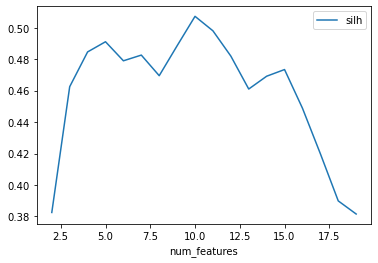

In [36]:
df_silh = pd.DataFrame(silh_dict).set_index("num_features")
df_silh.plot(kind="line")

In [53]:
best_num_feat = df_silh.reset_index().iloc[df_silh["silh"].argmax(), 0]
features_ = features_dict[best_num_feat]
features_

['area_worst',
 'texture_mean',
 'smoothness_mean',
 'concavity_mean',
 'fractal_dimension_mean',
 'radius_se',
 'symmetry_se',
 'concavity_se',
 'smoothness_worst',
 'concave_points_worst']

## Clustering: KMedoids (PAM)

In [64]:
X = df[features_].copy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in range(2, 10):
    clusters_pred = KMedoids(n_clusters=k, random_state=721).fit_predict(X)
        
    silh_avg_ = silhouette_score(X, clusters_pred)
    print(f"k={k}, silh={silh_avg_}")

k=2, silh=0.2645854907412834
k=3, silh=0.1619464698589692
k=4, silh=0.10141008839493307
k=5, silh=0.08904475433409988
k=6, silh=0.07532194546423317
k=7, silh=0.06723309401610282
k=8, silh=0.06292105457883823
k=9, silh=0.050102157336937965


## Visualizacion

In [67]:
k=2
clusters_pred = KMedoids(n_clusters=k, random_state=721).fit_predict(X)

In [73]:
comp = PCA(n_components=2).fit_transform(X)
comp = pd.DataFrame(comp, columns=["u1", "u2"])
comp["cluster"] = clusters_pred

<AxesSubplot:xlabel='u1', ylabel='u2'>

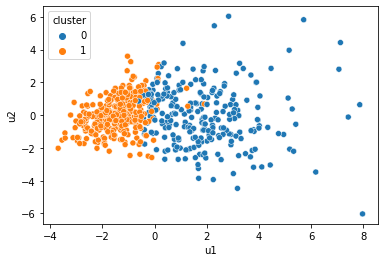

In [77]:
sns.scatterplot(x="u1", y="u2", hue="cluster", data=comp)

In [78]:
df["cluster"] = clusters_pred

In [81]:
df.groupby(["cluster"]).agg({"is_diagnosis_M": ["size", "sum", "mean"]})

is_diagnosis_M               
                  size  sum      mean
cluster                              
0                  249  191  0.767068
1                  320   21  0.065625

---